# Parameter Estimation and Latent Force based Filtering

Some introduction here summarized from the overleaf report

### Load necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import os
import pandas as pd
import datetime
import torch.nn as nn
import scipy.linalg as sla
from tqdm import trange
from torch.utils.data import Dataset, DataLoader

#import from parent folder
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import PDE

Dtype = torch.float

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Define discrete dynamics that will be used for system identification.

In [2]:
device

device(type='cpu')

In [3]:
'''
Construct system matrices corresponds to eq (16) in the overleaf document
parameters:
0 - D_T
1 - C_T
2 - K_3
3 - D_a
4 - C_a
5 - K_2
6 - D_v
7 - C_v
8 - E_v
9 - H_v
'''
def constructDiscreteSystemMatrices(log_parameters,nbases,L,measurement_points,samping_period,Der,Lap,O,I,H=None):
    #the original parameters is in the log space to assume that the parameters are positive
    parameters = torch.exp(log_parameters)

    D_T = parameters[0]
    C_T = parameters[1]
    K_3 = parameters[2]
    D_a = parameters[3]
    C_a = parameters[4]
    K_2 = parameters[5]
    D_v = parameters[6]
    C_v = parameters[7]
    E_v = parameters[8]
    H_v = parameters[9]

    A = torch.cat((
                    torch.cat((D_T*Lap-C_T*Der, O, K_3*H_v*I),dim=1),\
                    torch.cat((O,D_a*Lap-C_a*Der,-K_2*H_v*I),dim=1),\
                    torch.cat((O,O,D_v*Lap-C_v*Der),dim=1)))
    
    B = torch.cat((O,O,E_v*I))

    if H == None:
        index = torch.arange(1,nbases+1)
        Phi = PDE.basis(index,L,measurement_points)
        Oz = torch.zeros((measurement_points.shape[0],2*nbases))
        H = torch.cat((Phi.T,Oz),dim=1)

    F = PDE.expm(A*sampling_period)

    inv, _ = torch.solve(F-torch.eye(nbases*3),A)
    G = -inv@B

    return F,G,H

In [4]:
def negLogLikelihood(yTilde_hist,S_hist):
    loss = 0
    for i in range(yTilde_hist.shape[0]):
        loss += yTilde_hist[i,:]@S_hist[i,:,:]@yTilde_hist[i,:]
    
    return loss

def negLogLikelihoodFromParameters(log_parmeters,nbases,L,measurement_points,sampling_period,Der,Lap,O,I,H=None,R_factor=1.):
    F,G,H= constructDiscreteSystemMatrices(log_parmeters,nbases,L,measurement_points,sampling_period,Der,Lap,O,I,H)
    Q = G@G.T
    R = torch.eye(measurement_points.shape[0])*R_factor
    G_u = torch.zeros((nbases*3,1))
    kalman = PDE.KalmanFilter(F,G_u,H,Q,R,length=y_hist_normalized.shape[1])
    u = torch.tensor([0.])
    for i in range(kalman.length-1):
        kalman.propagate(u,y_hist_normalized[:,i])

    return negLogLikelihood(kalman.yTilde_history,kalman.S_history)

def adapt_step_sqrtBeta(current_step_size,current_acceptance_rate,feedback_gain=2.1,target_acceptance_rate=0.234):
        #based on Algorithm 2 of: Computational Methods for Bayesian Inference in Complex Systems: Thesis
        # self.set_step_sqrtBeta(self.pcn_step_sqrtBetas*np.exp(self.beta_feedback_gain*(current_acceptance_rate-self.target_acceptance_rate)))
        return current_step_size*np.exp(feedback_gain*(current_acceptance_rate-target_acceptance_rate))
        


## Define several variables




In [12]:
temperature_columns = np.array(
    [['TI8585','TI8553','TI8554','TI8555','TI8556','TI8557','TI8558','TI8559', 'TIZ8578A'],
     ['TI8585','TI8560','TI8561','TI8562','TI8563','TI8564','TI8565','TI8566', 'TIZ8578A'],
     ['TI8585','TI8567','TI8568','TI8569','TI8570','TI8571','TI8572','TI8573', 'TIZ8578A']],dtype=object)

tc_heights =np.array([[7600,6550,5500,4450,3400,2350,1300],
             [7250,6250,5150,4100,3050,2000,950],
             [6900,5850,4800,3750,2700,1650,600]])

tc_total_height=8000 #assumption
normalized_height = (tc_total_height-tc_heights)/tc_total_height
normalized_height = torch.from_numpy(normalized_height).float()

sampling_period = 1e-3# again assumption

nbases = 10
L = torch.tensor(1.)
#construct Continuous system matrices firsst


## Load data

In [13]:
df_raw = pd.read_hdf('../Data/timeseries_complete.hdf5',key='KAAPO_hour_15_16_17_18_19_complete')
df_raw = df_raw[(df_raw.index < "2017-03-26") & (df_raw.index > "2015-07-14")]
df_lab = pd.read_hdf('../Data/Laboratory.hdf5',key='Laboratory').interpolate()
df_lab = df_lab[(df_lab.index < "2017-03-26") & (df_lab.index > "2015-07-14")]
df = pd.concat([df_raw, df_lab], axis=1)
df = df.resample('d').median() #resample daily or weekly

y_hist = torch.tensor((df[temperature_columns[0,1:-1]]).values,device=device).float()
temp_inlet = torch.tensor(df['TI8585'].values,device=device).float()
y_hist_normalized = y_hist.T - temp_inlet
y_hist_normalized.shape

torch.Size([7, 621])

In [14]:
Der = PDE.derivative(nbases,L)
Lap = PDE.laplacian(nbases,L)
O = torch.zeros_like(Der)
I = torch.eye(Der.shape[0])

log_parameters = torch.ones(10)
F,G,H= constructDiscreteSystemMatrices(log_parameters,nbases,L,normalized_height[0,:],sampling_period,Der,Lap,O,I)
Q = G@G.T
R = torch.eye(normalized_height.shape[1])*1e-2
G_u = torch.zeros((nbases*3,1))
kalman = PDE.KalmanFilter(F,G_u,H,Q,R,length=y_hist_normalized.shape[1])
u = torch.tensor([0.])
for i in range(kalman.length-1):
    kalman.propagate(u,y_hist_normalized[:,i])


In [15]:
log_parameters

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


## Define preconditined Crank Nicolson
### Initialize the MCMC chain

In [ ]:
Der = PDE.derivative(nbases,L)
Lap = PDE.laplacian(nbases,L)
O = torch.zeros_like(Der)
I = torch.eye(Der.shape[0])
index = torch.arange(1,nbases+1)
Phi = PDE.basis(index,L,normalized_height[0,:])
Oz = torch.zeros((normalized_height.shape[1],2*nbases))
H = torch.cat((Phi.T,Oz),dim=1)

samples_length = 1000
sample_init = torch.randn(10)
samples = torch.empty((samples_length,sample_init.shape[0]))
samples[0,:] = sample_init
randw = torch.randn((samples_length,sample_init.shape[0]))
step_size = 1e-8
accepted = 0
partial_acceptance = 0
adaptation_steps = 10
latest_accepted_samples_neg_likelihood = negLogLikelihoodFromParameters(samples[0,:],nbases,L,normalized_height[0,:],sampling_period,Der,Lap,O,I,H=H)
with trange(1,samples_length) as t:
    
    # for i in trange(1,samples_length-1,desc='running MCMC, with acceptance rate = {}'.format(accepted/i)):
    for i in t:
        #pCN proposal
        new_sample = np.sqrt(1-np.square(step_size))*samples[i-1,:] + step_size*randw[i-1,:]

        #compute negloglikelihood for new sample
        new_neg_log_likelihood = negLogLikelihoodFromParameters(new_sample,nbases,L,normalized_height[0,:],sampling_period,Der,Lap,O,I,H=H)

        logRatio = latest_accepted_samples_neg_likelihood - new_neg_log_likelihood

        #compare
        if logRatio>np.log(np.random.rand()):
            latest_accepted_samples_neg_likelihood = new_neg_log_likelihood
            samples[i,:] = new_sample    
            accepted += 1
            partial_acceptance += 1
        else:
            samples[i,:] = samples[i-1,:]
            

        #adapt step_size
        if i%adaptation_steps == 0:
            step_size = adapt_step_sqrtBeta(step_size,partial_acceptance/adaptation_steps)
            # step_size = adapt_step_sqrtBeta(step_size,accepted/i)
            # print(step_size)
            #set back to zero
            partial_acceptance = 0
            t.set_description('running MCMC, with acceptance percentage = {}'.format(accepted*100/i))


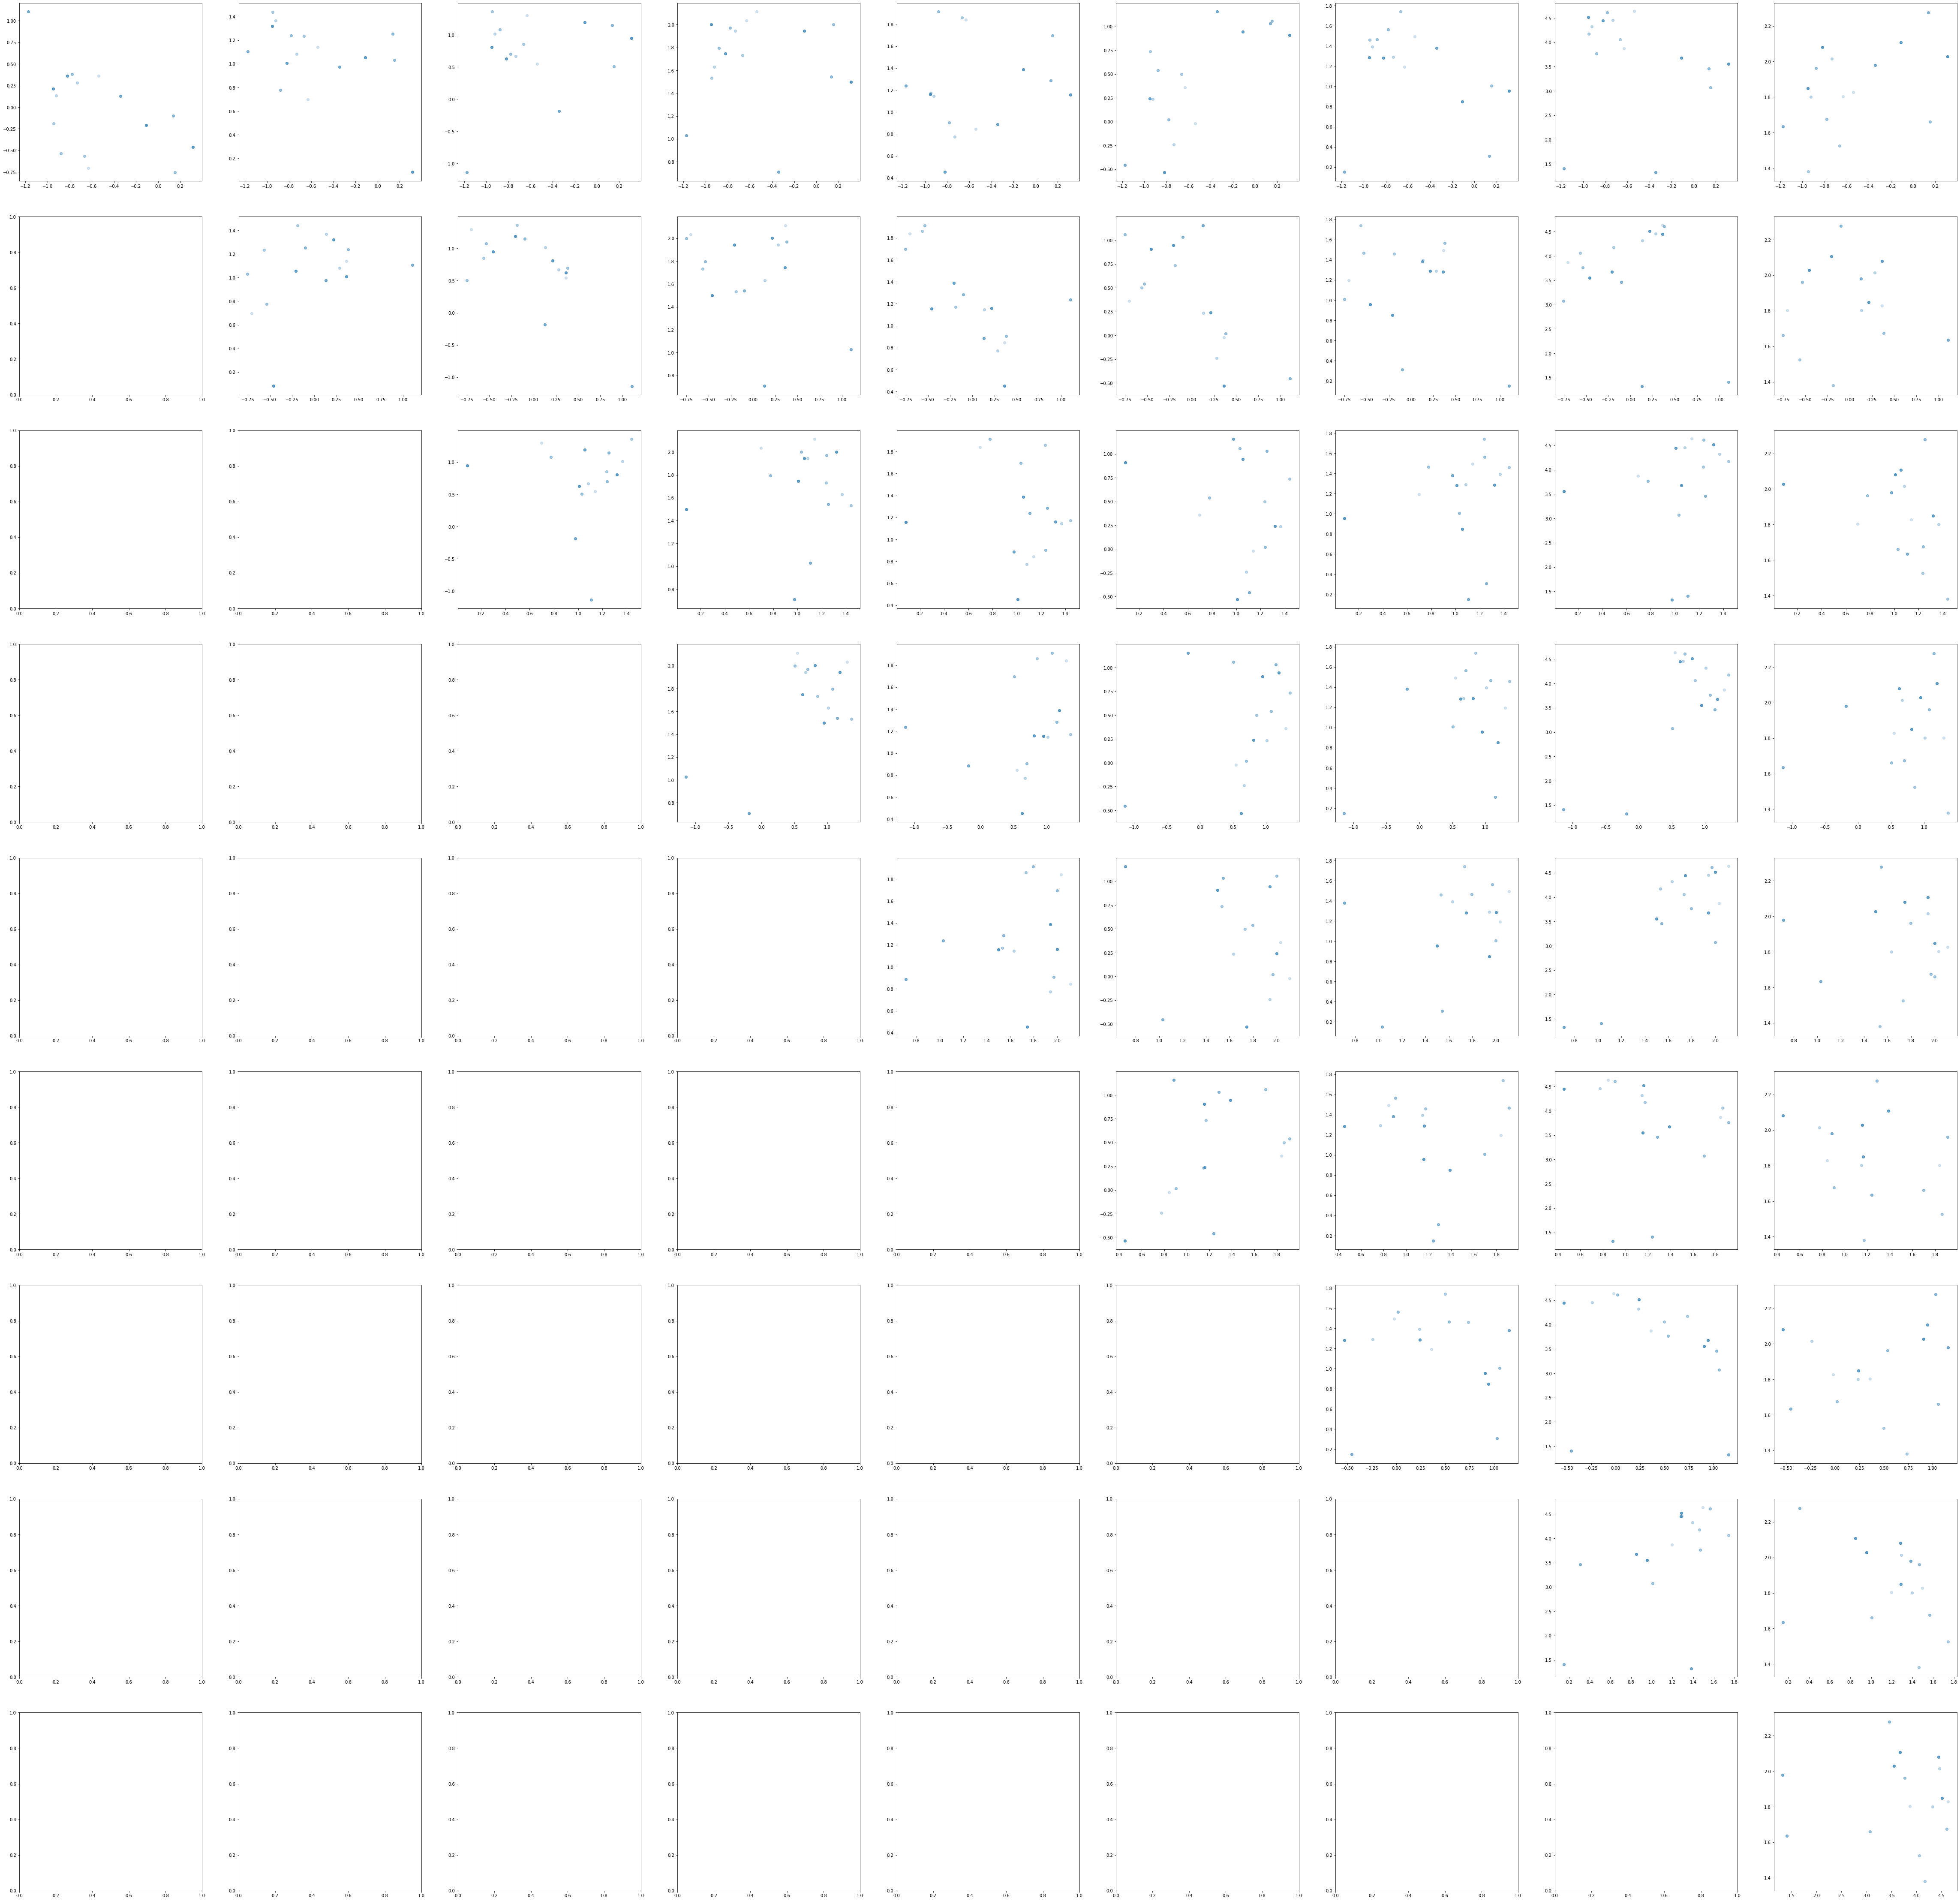

In [28]:
nparams = samples.shape[1]
f, ax = plt.subplots(nparams-1,nparams-1,figsize=(9*(nparams-1),9*(nparams-1)))
burned_index = samples_length//20
for i in range(nparams-1):
    for j in range(i+1,nparams):
        ax[i,j-1].scatter(samples[burned_index:,i],samples[burned_index:,j],alpha=0.1)

## Define costumized Torch.nn so that the parameter could be handled with Torch.optim algorithms
### Initialize the model

In [9]:
# initial_state = torch.zeros(nbases*3)
# initial_parameters = torch.ones(10)

# model = LatentForceParameterEstimation(device,initial_state,initial_parameters,normalized_height)

In [6]:
# #use Torch nn structure for easy manipulation of gradient and update
# class LatentForceParameterEstimation(nn.Module):
#     def __init__(self,device,initial_state,initial_parameters,normalized_tc_height):
#         super(LatentForceParameterEstimation,self).__init__()
#         self.normalized_tc_height = normalized_tc_height
#         self.pde_params = nn.Parameter(data=initial_parameters,requires_grad=True)        
#         self.initial_state = initial_state
#         F,G,H= constructDiscreteSystemMatrices(self.pde_params,nbases,L,normalized_height[0,:],sampling_period)
#         Q = G@G.T
#         R = torch.eye(normalized_height.shape[1])*1e-2
#         G_u = torch.zeros(nbases*3)
#         self.kalman = PDE.KalmanFilter(F,G_u,H,Q,R)
    
#     '''
#     forward, given a history of input u, the network will predict the history of output y
#     '''
#     def forward(self,y_hist):     
#         self.kalman.history_length = y_hist.shape[1]
#         u = torch.tensor([0.])
#         for i in range(kalman.length-1):
#             self.kalman.propagate(u,y_hist_normalized[:,i])

#         return self.kalman.yTilde_history,self.kalman.S_history